In [1]:
# !pip install spotipy

In [2]:
# !conda install -c conda-forge umap-learn

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import os
import re
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import umap.umap_ as umap
import altair as alt
from tqdm import tqdm
import time

In [4]:
# np.__version__

In [5]:
# pd.__version__

In [6]:
# Documentation:
# Client credentials:
#   https://developer.spotify.com/documentation/general/guides/app-settings/#register-your-app
#
# What each audio features means:
#   https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject
#   https://medium.com/@FinchMF/praise-questions-and-critique-spotify-api-38e984a4174b
# LUFS (Loudness):
#   https://www.sweetwater.com/insync/what-is-lufs-and-why-should-i-care/
# Scopes:
#   https://developer.spotify.com/documentation/general/guides/scopes/#user-library-read


# Examples:
#   https://www.researchgate.net/profile/Scott-Wolf/publication/342854806_Just_the_Way_You_Are_Linking_Music_Listening_on_Spotify_and_Personality/links/5f0bc62a92851c52d62f8a3a/Just-the-Way-You-Are-Linking-Music-Listening-on-Spotify-and-Personality.pdf
#   https://www.diva-portal.org/smash/get/diva2:1108465/FULLTEXT02
#   https://ieeexplore.ieee.org/abstract/document/7987199
#   https://www.math.vu.nl/~sbhulai/papers/paper-vandenhoven.pdf
#   https://towardsdatascience.com/discovering-your-music-taste-with-python-and-spotify-api-b51b0d2744d
#   https://towardsdatascience.com/a-music-taste-analysis-using-spotify-api-and-python-e52d186db5fc
#   https://rareloot.medium.com/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330

# Cluster
# https://martinfleischmann.net/clustergam-visualisation-of-cluster-analysis/

In [7]:
os.environ["SPOTIPY_CLIENT_ID"] = "e93bb9b7b8aa4ba8a817537a0f7696f8"
os.environ["SPOTIPY_CLIENT_SECRET"] = "bd54ecc86e3b4bc08b33f3bed6e89dee"
os.environ['SPOTIPY_REDIRECT_URI'] = "http://localhost:8080"   # Needed for user authorization

In [8]:
  # acousticness: 0.0 to 1.0,   1 is acoustic

  # danceability: 0.0 to 1.0,   1 is most danceable

  # energy: 0.0 to 1.0, perceptual measure of intensity and activity. 1.0 energetic tracks feel fast, loud and noisy. 
  #     Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.  
  
  # instrumentalness: 0.0 to 1.0, predicts whether a track contains no vocals (is instrumental).  1.0 is pure intrumental. Above 0.5 represent instrumental tracks.  
  
  # key:  Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.    I still don't understand this :/

  # liveness: 0.0 to 1.0, presence of audience in the recording. 0.8 or above strong likelihood that the track is live.

  # loudness: -60.0 to 0.0db,  Negative number, closer to 0 is louder.

  # mode: 0 or 1, Minor=0 Major=1, Major is happier

  # speechiness: 0.0 to 1.0, detects presence of spoken words. 1.0 is talk show or audio book. 
  #     Values above 0.66 describe tracks that are probably made entirely of spoken words. 
  #     Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. 
  #     Values below 0.33 most likely represent music and other non-speech-like tracks.

  # tempo: BPM, Beats per minute 
  
  # valence: 0.0 to 1.0, describing musical positiveness, the higher the more positive. 
  
  # analysis_url: 
  # duration_ms: 238854,
  # id: '1eT2CjXwFXNx6oY5ydvzKU',
  # time_signature: 4,
  # track_href: 'https://api.spotify.com/v1/tracks/1eT2CjXwFXNx6oY5ydvzKU',
  # type: 'audio_features',
  # uri: 'spotify:track:1eT2CjXwFXNx6oY5ydvzKU',

In [9]:
# Example code without user authorization
urn = 'spotify:artist:3jOstUTkEu2JkjvRdBA5Gu'
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

artist = sp.artist(urn)

user = sp.user('plamere')

track = sp.track('2nLtzopw4rPReszdYBJU6h')

audio_features = sp.audio_features('1eT2CjXwFXNx6oY5ydvzKU')

In [10]:
# sp.recommendation_genre_seeds()

In [11]:
# Get access with user authorization
scope = 'user-library-read user-follow-read'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [12]:
# # Quick display of all saved songs
# def show_tracks(results):
#     for item in results['items']:
#         track = item['track']
#         print("%32.32s %s" % (track['artists'][0]['name'], track['name']))
        
# results = sp.current_user_saved_tracks()
# show_tracks(results)

# while results['next']:
#     results = sp.next(results)
#     show_tracks(results)

In [13]:
# Get all tracks and save them to lists to construct dataframe
tracks = sp.current_user_saved_tracks()

song = []
artist = []
uri = []

#First pass of the saved tracks
for i in tracks['items']:
    song.append(i['track']['name'])
    artist.append(i['track']['artists'][0]['name'])
    uri_id = i['track']['uri']
    uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

# Keep looking in tracks for the rest of the saved tracks, they are paginated
while tracks['next']:
    tracks = sp.next(tracks)
    for i in tracks['items']:
        song.append(i['track']['name'])
        artist.append(i['track']['artists'][0]['name'])
        uri_id = i['track']['uri']
        uri.append(re.search('(^spotify:track:([^\s]+))', uri_id).groups()[1])

In [14]:
# Create a dataframe from info extracted above, song, artist and uri
songs_df = pd.DataFrame(
    {'song': song,
     'artist': artist,
     'uri': uri
    })

In [15]:
songs_df

song             artist                     uri
0                Colores           Pastilla  2bhLp7bxyvH9PJy2lfVViZ
1                Desnuda         Mama Pulpa  62T5V920LEjhKJRtAu2z5x
2                   Acid       Ray Barretto  4J4S8Fm2BJt59zPWygsbpr
3           Último Tramo          Diegoshky  1AgmWCxnUio5kMDH4QxPaq
4                 Viento    Gianluca Vacchi  6ldrrA9dkZjIrX4wUOXTz2
...                  ...                ...                     ...
1210     I Get Like This     The Hard Aches  0optHnDvpfxtft4D0tTetQ
1211       Fall Together    The Temper Trap  6bi9JGOCgrUXPICsfrJLP7
1212  Walking On A Dream  Empire of the Sun  0mBkoM8r7KAQzZij5swTUL
1213              Palmar           Caloncho  06FhHrnpYCmIxIxIGUehxQ
1214          Sabor a Mi    Monsieur Periné  6Ghqj5i94yxy3uSAnpQljL

[1215 rows x 3 columns]

In [16]:
pd.DataFrame(sp.audio_features(i)[0], index=[i,])

Empty DataFrame
Columns: []
Index: [{'added_at': '2016-06-08T17:18:31Z', 'track': {'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/36KsCCwgI0Dep97yVJWmkK'}, 'href': 'https://api.spotify.com/v1/artists/36KsCCwgI0Dep97yVJWmkK', 'id': '36KsCCwgI0Dep97yVJWmkK', 'name': 'Monsieur Periné', 'type': 'artist', 'uri': 'spotify:artist:36KsCCwgI0Dep97yVJWmkK'}], 'available_markets': [], 'external_urls': {'spotify': 'https://open.spotify.com/album/0HLPr4c2d1vlhIA3yOZqtS'}, 'href': 'https://api.spotify.com/v1/albums/0HLPr4c2d1vlhIA3yOZqtS', 'id': '0HLPr4c2d1vlhIA3yOZqtS', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b2739e25fda55d9130e20304711c', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e029e25fda55d9130e20304711c', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/ab67616d000048519e25fda55d9130e20304711c', 'width': 64}], 'name': 'Hecho a Mano', 'release_date': '2012-06-20', 'release_date_precision': 'day', 'total_tracks': 12, 'type': 'album', 'uri': 'spotify:album:0HLPr4c2d1vlhIA3yOZqtS'}, 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/36KsCCwgI0Dep97yVJWmkK'}, 'href': 'https://api.spotify.com/v1/artists/36KsCCwgI0Dep97yVJWmkK', 'id': '36KsCCwgI0Dep97yVJWmkK', 'name': 'Monsieur Periné', 'type': 'artist', 'uri': 'spotify:artist:36KsCCwgI0Dep97yVJWmkK'}], 'available_markets': [], 'disc_number': 1, 'duration_ms': 197480, 'explicit': False, 'external_ids': {'isrc': 'TCABH1224585'}, 'external_urls': {'spotify': 'https://open.spotify.com/track/6Ghqj5i94yxy3uSAnpQljL'}, 'href': 'https://api.spotify.com/v1/tracks/6Ghqj5i94yxy3uSAnpQljL', 'id': '6Ghqj5i94yxy3uSAnpQljL', 'is_local': False, 'name': 'Sabor a Mi', 'popularity': 0, 'preview_url': None, 'track_number': 4, 'type': 'track', 'uri': 'spotify:track:6Ghqj5i94yxy3uSAnpQljL'}}]

In [17]:
# Extract audio features from each song and create a dataframe
appended_df = []
for i in uri:
    appended_df.append(pd.DataFrame(sp.audio_features(i)[0], index=[i,]))
uri_df = pd.concat(appended_df)
uri_df = uri_df.drop(['uri'], axis=1)
uri_df = uri_df.reset_index()
uri_df = uri_df.rename(columns={"index": "uri"})

In [18]:
saved_songs_df = pd.merge(songs_df, uri_df, on="uri")

In [19]:
saved_songs_df.head()

song           artist                     uri  danceability  \
0       Colores         Pastilla  2bhLp7bxyvH9PJy2lfVViZ         0.496   
1       Desnuda       Mama Pulpa  62T5V920LEjhKJRtAu2z5x         0.458   
2          Acid     Ray Barretto  4J4S8Fm2BJt59zPWygsbpr         0.555   
3  Último Tramo        Diegoshky  1AgmWCxnUio5kMDH4QxPaq         0.481   
4        Viento  Gianluca Vacchi  6ldrrA9dkZjIrX4wUOXTz2         0.659   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.955    4    -4.921     1       0.0538        0.0102          0.000019   
1   0.696    1   -10.880     0       0.1330        0.0146          0.032700   
2   0.659    0    -8.529     1       0.0575        0.0374          0.851000   
3   0.412    7   -10.018     1       0.0294        0.4450          0.000001   
4   0.971    3    -3.818     0       0.0527        0.0037          0.012900   

   liveness  valence    tempo            type                      id  \
0    0.3690    0.894  152.994  audio_features  2bhLp7bxyvH9PJy2lfVViZ   
1    0.0867    0.200  195.084  audio_features  62T5V920LEjhKJRtAu2z5x   
2    0.0788    0.937  159.063  audio_features  4J4S8Fm2BJt59zPWygsbpr   
3    0.3610    0.203  167.968  audio_features  1AgmWCxnUio5kMDH4QxPaq   
4    0.0926    0.343  126.014  audio_features  6ldrrA9dkZjIrX4wUOXTz2   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2bhLp7bxyvH9...   
1  https://api.spotify.com/v1/tracks/62T5V920LEjh...   
2  https://api.spotify.com/v1/tracks/4J4S8Fm2BJt5...   
3  https://api.spotify.com/v1/tracks/1AgmWCxnUio5...   
4  https://api.spotify.com/v1/tracks/6ldrrA9dkZjI...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2bhL...       188733   
1  https://api.spotify.com/v1/audio-analysis/62T5...       268000   
2  https://api.spotify.com/v1/audio-analysis/4J4S...       307173   
3  https://api.spotify.com/v1/audio-analysis/1Agm...       203152   
4  https://api.spotify.com/v1/audio-analysis/6ldr...       228690   

   time_signature  
0               4  
1               3  
2               4  
3               4  
4               4

In [20]:
saved_songs_df.describe()

danceability       energy          key     loudness         mode  \
count   1215.000000  1215.000000  1215.000000  1215.000000  1215.000000   
mean       0.641356     0.706920     5.108642    -6.441809     0.650206   
std        0.132243     0.178963     3.625788     2.712619     0.477101   
min        0.130000     0.034600     0.000000   -25.579000     0.000000   
25%        0.557500     0.601500     2.000000    -7.726000     0.000000   
50%        0.655000     0.736000     5.000000    -5.935000     1.000000   
75%        0.736000     0.844500     8.000000    -4.665000     1.000000   
max        0.974000     0.997000    11.000000    -0.611000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  1215.000000   1215.000000       1215.000000  1215.000000  1215.000000   
mean      0.075170      0.207055          0.068149     0.191620     0.569443   
std       0.071971      0.248668          0.192106     0.168747     0.237668   
min       0.023900      0.000005          0.000000     0.024700     0.032400   
25%       0.035700      0.021400          0.000000     0.091300     0.389000   
50%       0.048000      0.095100          0.000027     0.123000     0.576000   
75%       0.081900      0.313500          0.005640     0.240000     0.764000   
max       0.614000      0.975000          0.940000     0.983000     0.982000   

             tempo    duration_ms  time_signature  
count  1215.000000    1215.000000     1215.000000  
mean    121.716404  231394.113580        3.968724  
std      27.450809   55775.451467        0.231056  
min      59.406000   40533.000000        1.000000  
25%     100.023000  200129.500000        4.000000  
50%     120.008000  221647.000000        4.000000  
75%     139.949500  252604.500000        4.000000  
max     205.070000  662615.000000        5.000000

In [21]:
radar_df = saved_songs_df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                           'instrumentalness', 'liveness', 'valence']]

In [22]:
radar_df.describe()

danceability       energy     loudness  speechiness  acousticness  \
count   1215.000000  1215.000000  1215.000000  1215.000000   1215.000000   
mean       0.641356     0.706920    -6.441809     0.075170      0.207055   
std        0.132243     0.178963     2.712619     0.071971      0.248668   
min        0.130000     0.034600   -25.579000     0.023900      0.000005   
25%        0.557500     0.601500    -7.726000     0.035700      0.021400   
50%        0.655000     0.736000    -5.935000     0.048000      0.095100   
75%        0.736000     0.844500    -4.665000     0.081900      0.313500   
max        0.974000     0.997000    -0.611000     0.614000      0.975000   

       instrumentalness     liveness      valence  
count       1215.000000  1215.000000  1215.000000  
mean           0.068149     0.191620     0.569443  
std            0.192106     0.168747     0.237668  
min            0.000000     0.024700     0.032400  
25%            0.000000     0.091300     0.389000  
50%            0.000027     0.123000     0.576000  
75%            0.005640     0.240000     0.764000  
max            0.940000     0.983000     0.982000

In [23]:
min_max_scaler = MinMaxScaler()
radar_df['loudness'] = min_max_scaler.fit_transform(radar_df['loudness'].to_numpy().reshape(-1, 1))
radar_df.describe()

danceability       energy     loudness  speechiness  acousticness  \
count   1215.000000  1215.000000  1215.000000  1215.000000   1215.000000   
mean       0.641356     0.706920     0.766469     0.075170      0.207055   
std        0.132243     0.178963     0.108644     0.071971      0.248668   
min        0.130000     0.034600     0.000000     0.023900      0.000005   
25%        0.557500     0.601500     0.715035     0.035700      0.021400   
50%        0.655000     0.736000     0.786767     0.048000      0.095100   
75%        0.736000     0.844500     0.837632     0.081900      0.313500   
max        0.974000     0.997000     1.000000     0.614000      0.975000   

       instrumentalness     liveness      valence  
count       1215.000000  1215.000000  1215.000000  
mean           0.068149     0.191620     0.569443  
std            0.192106     0.168747     0.237668  
min            0.000000     0.024700     0.032400  
25%            0.000000     0.091300     0.389000  
50%            0.000027     0.123000     0.576000  
75%            0.005640     0.240000     0.764000  
max            0.940000     0.983000     0.982000

In [24]:
# convert column names into a list
categories=list(radar_df.columns)
# number of categories
N=len(categories)

# create a list with the average of all features
value=list(radar_df.mean())

In [25]:
fig = px.line_polar(radar_df, r=value, theta=categories, line_close=True, range_r=[0,1])
fig.update_traces(fill='toself')
fig.show()

In [26]:
saved_songs_df.head()

song           artist                     uri  danceability  \
0       Colores         Pastilla  2bhLp7bxyvH9PJy2lfVViZ         0.496   
1       Desnuda       Mama Pulpa  62T5V920LEjhKJRtAu2z5x         0.458   
2          Acid     Ray Barretto  4J4S8Fm2BJt59zPWygsbpr         0.555   
3  Último Tramo        Diegoshky  1AgmWCxnUio5kMDH4QxPaq         0.481   
4        Viento  Gianluca Vacchi  6ldrrA9dkZjIrX4wUOXTz2         0.659   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.955    4    -4.921     1       0.0538        0.0102          0.000019   
1   0.696    1   -10.880     0       0.1330        0.0146          0.032700   
2   0.659    0    -8.529     1       0.0575        0.0374          0.851000   
3   0.412    7   -10.018     1       0.0294        0.4450          0.000001   
4   0.971    3    -3.818     0       0.0527        0.0037          0.012900   

   liveness  valence    tempo            type                      id  \
0    0.3690    0.894  152.994  audio_features  2bhLp7bxyvH9PJy2lfVViZ   
1    0.0867    0.200  195.084  audio_features  62T5V920LEjhKJRtAu2z5x   
2    0.0788    0.937  159.063  audio_features  4J4S8Fm2BJt59zPWygsbpr   
3    0.3610    0.203  167.968  audio_features  1AgmWCxnUio5kMDH4QxPaq   
4    0.0926    0.343  126.014  audio_features  6ldrrA9dkZjIrX4wUOXTz2   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2bhLp7bxyvH9...   
1  https://api.spotify.com/v1/tracks/62T5V920LEjh...   
2  https://api.spotify.com/v1/tracks/4J4S8Fm2BJt5...   
3  https://api.spotify.com/v1/tracks/1AgmWCxnUio5...   
4  https://api.spotify.com/v1/tracks/6ldrrA9dkZjI...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/2bhL...       188733   
1  https://api.spotify.com/v1/audio-analysis/62T5...       268000   
2  https://api.spotify.com/v1/audio-analysis/4J4S...       307173   
3  https://api.spotify.com/v1/audio-analysis/1Agm...       203152   
4  https://api.spotify.com/v1/audio-analysis/6ldr...       228690   

   time_signature  
0               4  
1               3  
2               4  
3               4  
4               4

array([[<AxesSubplot:xlabel='danceability', ylabel='danceability'>,
        <AxesSubplot:xlabel='energy', ylabel='danceability'>,
        <AxesSubplot:xlabel='key', ylabel='danceability'>,
        <AxesSubplot:xlabel='loudness', ylabel='danceability'>,
        <AxesSubplot:xlabel='mode', ylabel='danceability'>,
        <AxesSubplot:xlabel='speechiness', ylabel='danceability'>,
        <AxesSubplot:xlabel='acousticness', ylabel='danceability'>,
        <AxesSubplot:xlabel='instrumentalness', ylabel='danceability'>,
        <AxesSubplot:xlabel='liveness', ylabel='danceability'>,
        <AxesSubplot:xlabel='valence', ylabel='danceability'>,
        <AxesSubplot:xlabel='tempo', ylabel='danceability'>,
        <AxesSubplot:xlabel='duration_ms', ylabel='danceability'>,
        <AxesSubplot:xlabel='time_signature', ylabel='danceability'>],
       [<AxesSubplot:xlabel='danceability', ylabel='energy'>,
        <AxesSubplot:xlabel='energy', ylabel='energy'>,
        <AxesSubplot:xlabel='key', y

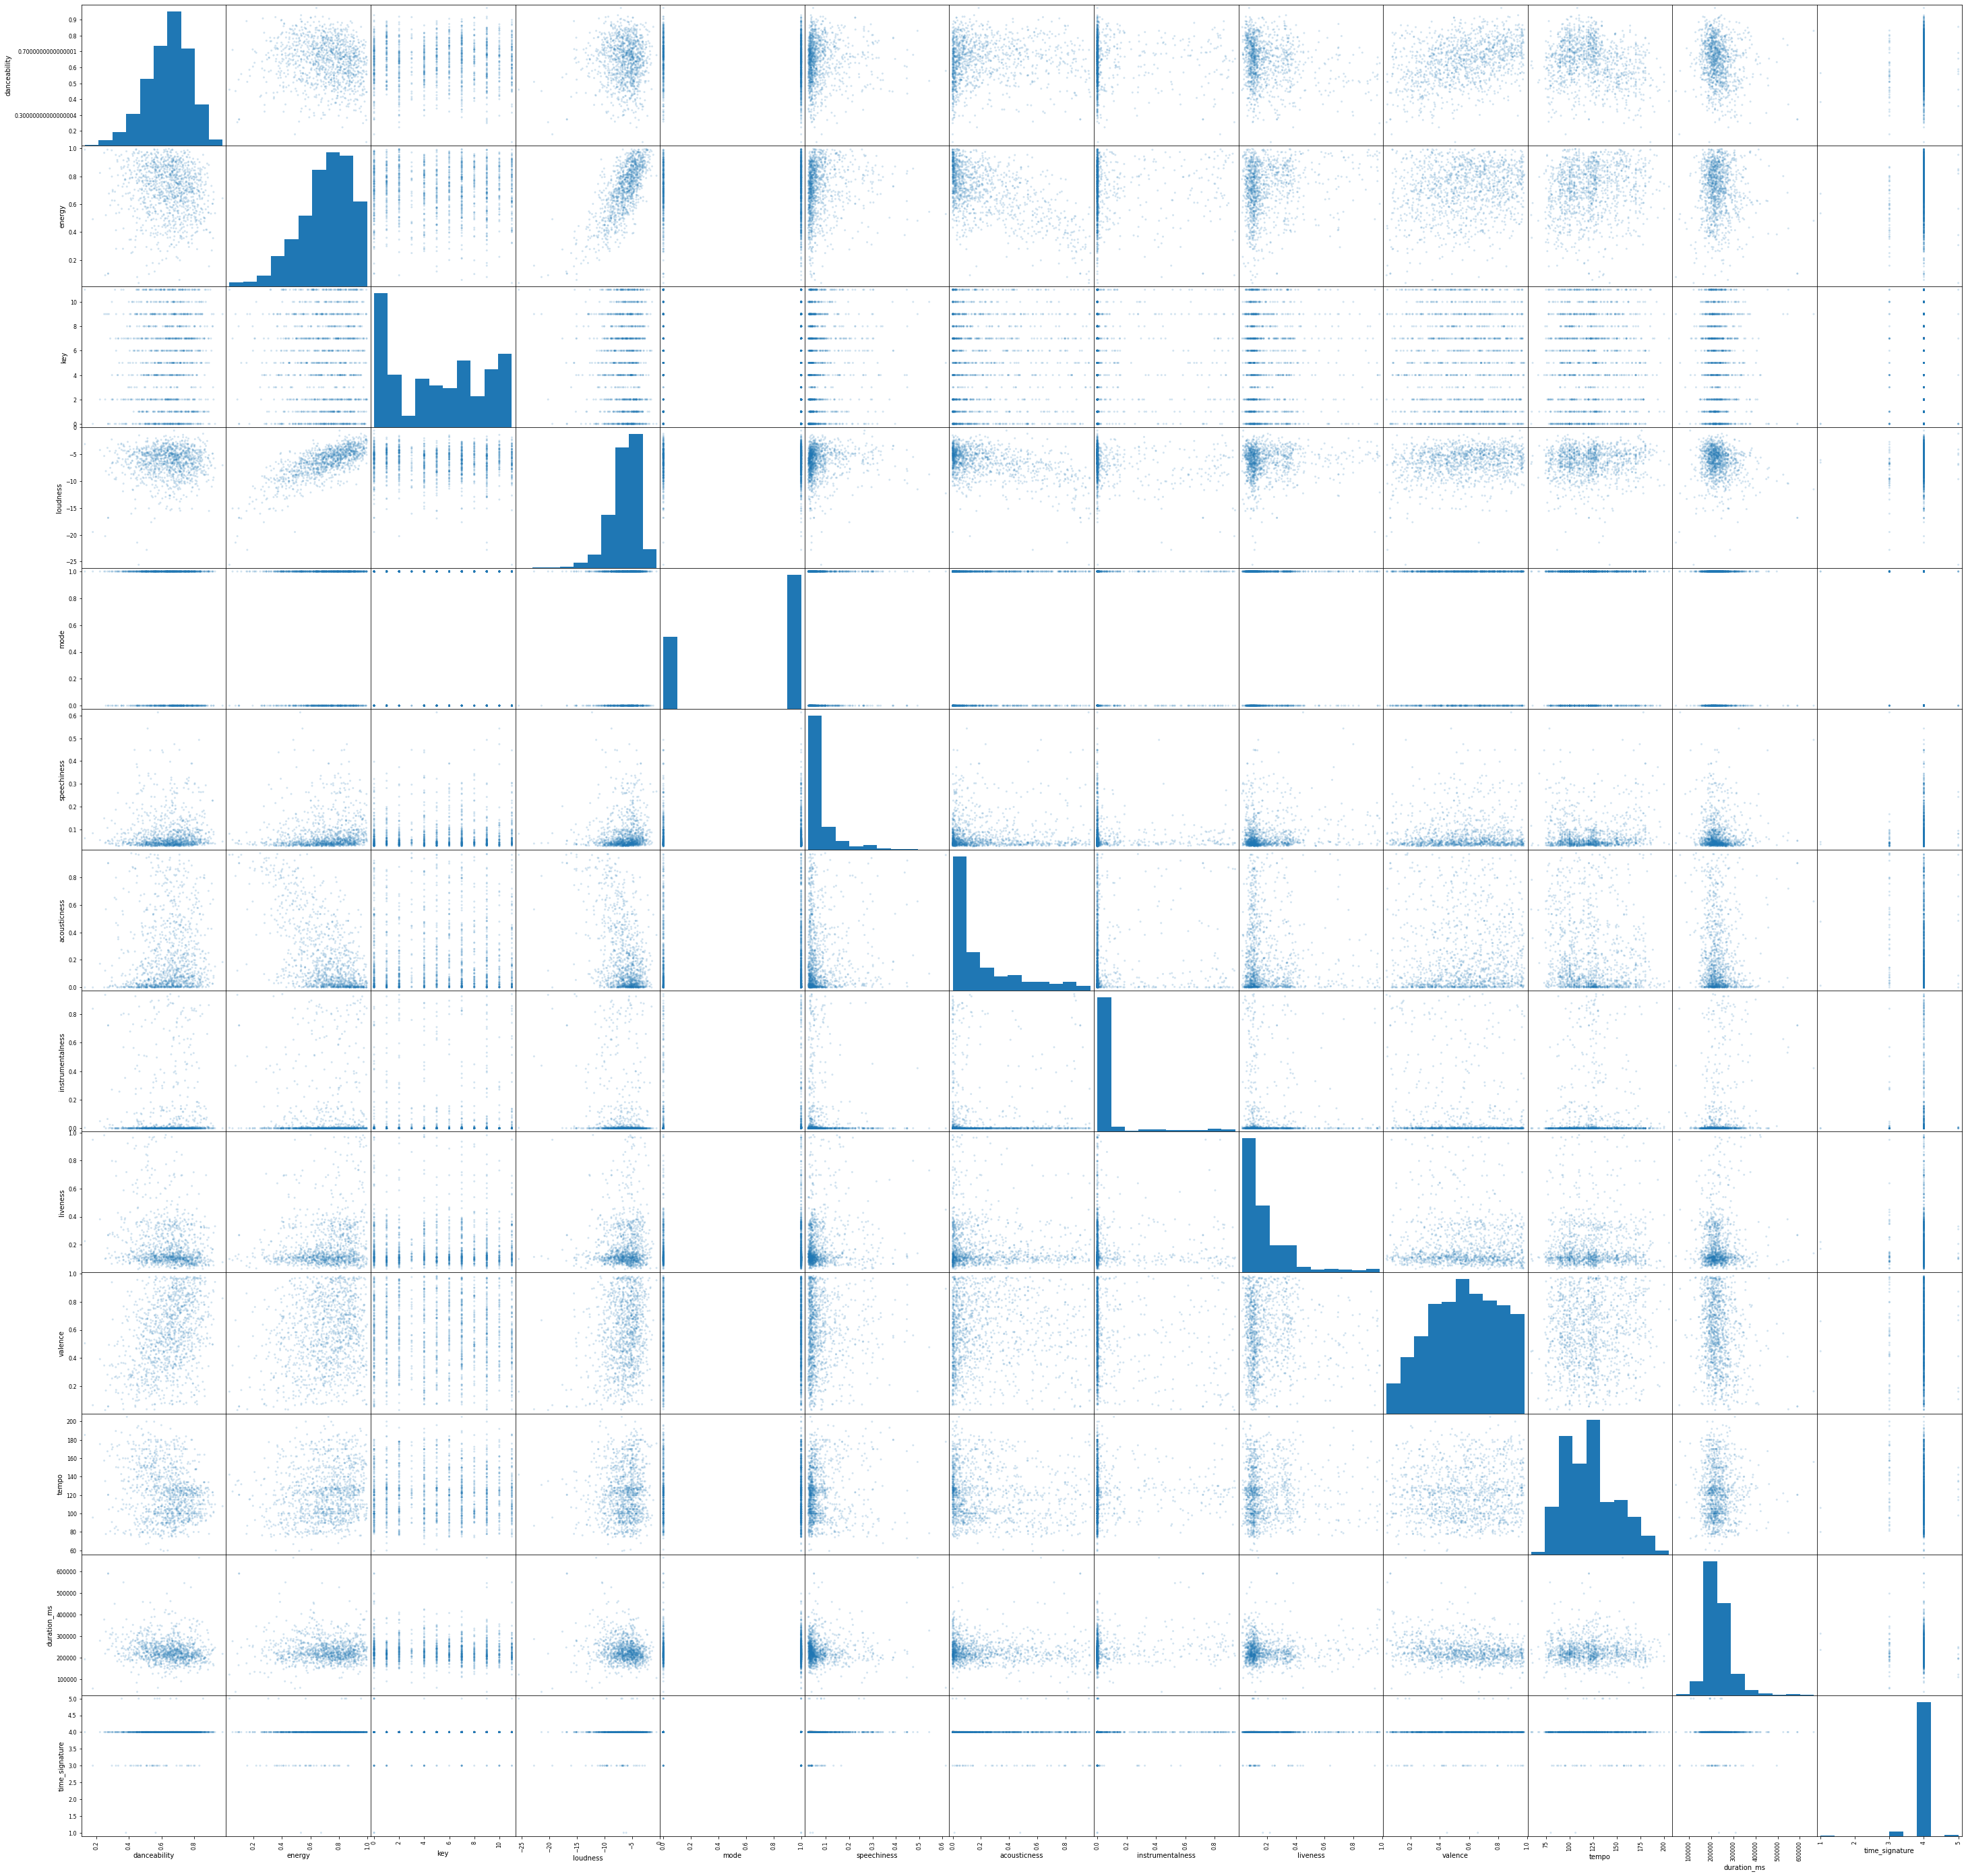

In [27]:
pd.plotting.scatter_matrix(saved_songs_df, alpha=0.2, figsize=(50,50))


In [28]:
# Columns of interest
saved_songs_df[['uri', 'danceability','energy','key','loudness','mode','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo', 'duration_ms','time_signature']].head()

uri  danceability  energy  key  loudness  mode  \
0  2bhLp7bxyvH9PJy2lfVViZ         0.496   0.955    4    -4.921     1   
1  62T5V920LEjhKJRtAu2z5x         0.458   0.696    1   -10.880     0   
2  4J4S8Fm2BJt59zPWygsbpr         0.555   0.659    0    -8.529     1   
3  1AgmWCxnUio5kMDH4QxPaq         0.481   0.412    7   -10.018     1   
4  6ldrrA9dkZjIrX4wUOXTz2         0.659   0.971    3    -3.818     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0538        0.0102          0.000019    0.3690    0.894  152.994   
1       0.1330        0.0146          0.032700    0.0867    0.200  195.084   
2       0.0575        0.0374          0.851000    0.0788    0.937  159.063   
3       0.0294        0.4450          0.000001    0.3610    0.203  167.968   
4       0.0527        0.0037          0.012900    0.0926    0.343  126.014   

   duration_ms  time_signature  
0       188733               4  
1       268000               3  
2       307173               4  
3       203152               4  
4       228690               4

In [29]:
# Creating the df with columns of interest
feature_names = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo', 'duration_ms','time_signature']
df = saved_songs_df[feature_names]
df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.496   0.955    4    -4.921     1       0.0538        0.0102   
1         0.458   0.696    1   -10.880     0       0.1330        0.0146   
2         0.555   0.659    0    -8.529     1       0.0575        0.0374   
3         0.481   0.412    7   -10.018     1       0.0294        0.4450   
4         0.659   0.971    3    -3.818     0       0.0527        0.0037   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.000019    0.3690    0.894  152.994       188733               4  
1          0.032700    0.0867    0.200  195.084       268000               3  
2          0.851000    0.0788    0.937  159.063       307173               4  
3          0.000001    0.3610    0.203  167.968       203152               4  
4          0.012900    0.0926    0.343  126.014       228690               4

In [30]:
# Not sure if I want to keep because new songs might have different scale.
StdScaler = StandardScaler().fit(df).transform(df)

In [31]:
# Running PCA
pca = PCA(n_components = 3, random_state = 0).fit(StdScaler)

In [32]:
# Calculating variance for each principal component
singularValues = pca.singular_values_
variance = np.square(singularValues)/(len(StdScaler)-1)
variance

array([2.37055824, 1.66618237, 1.25903509])

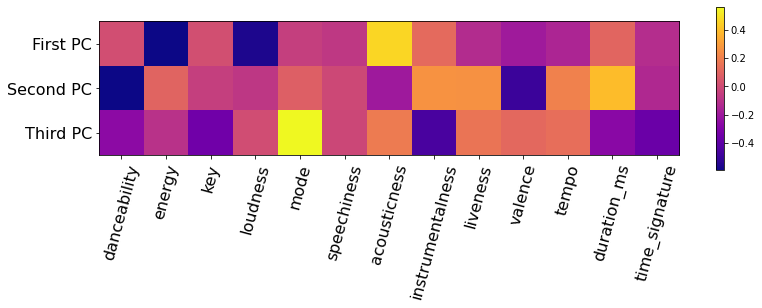

In [33]:
def plot_pca_heatmap(pca, feature_names):
    pc_names = ['First PC', 'Second PC', 'Third PC']
    fig, ax = plt.subplots(figsize=(len(feature_names), 3))
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    feature_names=list(feature_names)
    plt.xticks(np.arange(0, len(feature_names), 1) , feature_names[:], rotation = 75, fontsize=16)
    plt.yticks(np.arange(0.0, 3, 1), pc_names, fontsize = 16)
    plt.colorbar()



plot_pca_heatmap(pca, feature_names)

<Figure size 432x288 with 0 Axes>

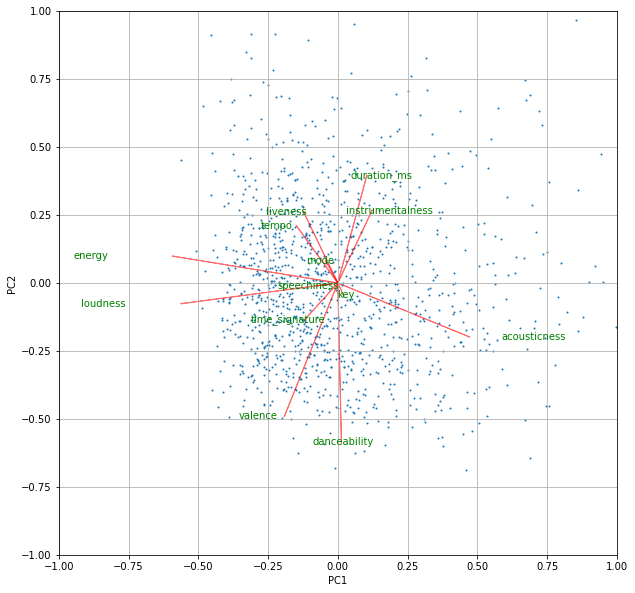

In [34]:
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 1.5
    plt.scatter(xs*scalex, ys*scaley, s=1)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2] * text_scale_factor, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

plt.figure()
plt.figure(figsize=(10, 10))

# Uncomment this code to generate the biplot using your previous answers
X_normalized = StdScaler
X_pca = pca.transform(X_normalized)
biplot(X_pca, np.transpose(pca.components_[0:2, :]), len(feature_names), 1, 2, labels=feature_names[:])

In [35]:
X_pca = PCA(n_components = 2).fit_transform(StdScaler)
X_tsne = TSNE(n_components = 2, random_state = 42).fit_transform(StdScaler)
X_mds = MDS(n_components = 2, random_state = 42).fit_transform(StdScaler)

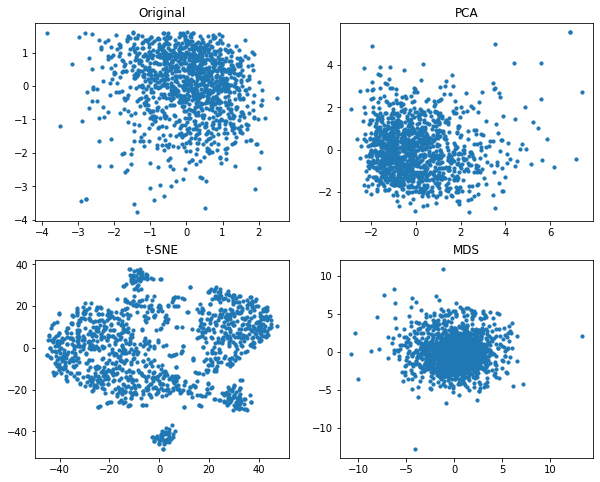

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


axes[0, 0].scatter(StdScaler[:, 0], StdScaler[:, 1], s=10)
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], s=10)
axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10)
axes[1, 1].scatter(X_mds[:, 0], X_mds[:, 1], s=10)

axes[0, 0].set_title("Original")
axes[0, 1].set_title("PCA")
axes[1, 0].set_title("t-SNE")
axes[1, 1].set_title("MDS")
del fig, axes

In [37]:
# get index from songs given X and Y coordinates on t-SNE
songs_index = (np.where((X_tsne[:,0] <= -20) & (X_tsne[:,1] >= 15)))
saved_songs_df.iloc[songs_index]

song  \
0                                               Colores   
16                               Too Much Time Together   
21                               Too Much Time Together   
26    Vespa Special - Spanish Version - Remastered 2019   
32                                    Another Sunny Day   
53                                            Australia   
89                                 Mojarrita - Acústico   
94                                             Rockstar   
126                                            Perfecta   
159                                            The Girl   
174                                           Beautiful   
238                                        Ella Es Azul   
263                                        Jaque al Rey   
349                                   Antídoto Perfecto   
398                                         Una Ilusion   
479             Déjala Que Vuelva (feat. Manuel Turizo)   
487                            El Mercado De Los Brujos   
518                                             Camello   
537                                           The Twist   
631                                            Una Flor   
675                                            Big Boys   
714                                              Genial   
790                                     Bajo vigilancia   
794                                       Radio Falacia   
862                                      Safe And Sound   
884                                       Silver & Gold   
889                                       Toro mecánico   
891                                             Bourbon   
892                              Homenaje a Los Ramones   
952                                         Light Years   
968                             Gyal You A Party Animal   
992                                  Las Pequeñas Cosas   
1167                                            Ay Amor   

                      artist                     uri  danceability  energy  \
0                   Pastilla  2bhLp7bxyvH9PJy2lfVViZ         0.496   0.955   
16                 San Cisco  0LeouSB6kxdNKFw51vkYtC         0.564   0.841   
21                 San Cisco  0LcVvD1iPjqkfVdWd7ClfA         0.563   0.841   
26                   Lùnapop  0izPVmKKBIxanarBVzD0IQ         0.503   0.916   
32         Belle & Sebastian  07ZSQZzH92n1uwEG0m8M4f         0.405   0.783   
53                 The Shins  47TQjzeG4KI0XWWb0wkbri         0.416   0.827   
89             Los Caligaris  0POxNBmD5ibWZ6Y1Tj83tp         0.680   0.680   
94                Nickelback  3RlsVPIIs5KFhLFhxZ4iDF         0.616   0.910   
126                 Miranda!  09QfIIP4NUx4A3thmovb2o         0.648   0.727   
159              Maxi Trusso  6Se2bD9zz9bE5UwHCDKTUh         0.536   0.697   
174                     Moby  1zcj2Mnmi9cxfGPU27jpOJ         0.491   0.648   
238                  Volován  3FEOiLNmS51wlq4ZcouLj6         0.466   0.886   
263                    Ska-P  3LoprIhRSYXR01TIysmLZc         0.673   0.932   
349             Timo Pacheco  7HAXJPxW5ECL145IxUn6Wi         0.589   0.835   
398                    Kabah  03MVOU4cDr5FoJcOoznVid         0.721   0.976   
479                  Piso 21  33bnxcjePIkcmNjEFTJX0l         0.681   0.788   
487       Sonido Gallo Negro  7voARGnid2KFMdW4sFWZgs         0.442   0.792   
518            Los Caligaris  7r2o53Emfp2ibH1IXeagGw         0.657   0.802   
537           Chubby Checker  6DSvUZQdqtNfkJI4cAiUsM         0.525   0.838   
631                   Juanes  03lziG35E9nVvpJJrCuIjH         0.577   0.868   
675              Chuck Berry  44ljyjfLTjjS3XuzoFh3Z5         0.559   0.962   
714            Pequeño Fénix  2k6sPzIcpOsxPTLoqjVXhG         0.621   0.828   
790                    Ska-P  6eNvEkccEvC1Hfpl1Dmz3t         0.653   0.974   
794                    Ska-P  1OLeA7XF2FYCbz4Vhgwp9p         0.658   0.986   
862           Capital Cities  6Z8R6UsFuGXGtiIxiD8ISb         0.655   0.819   
884             

In [38]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_tsne)
cluster = pd.DataFrame(X_tsne,columns=['x','y'])
cluster['cluster'] = kmeans.labels_

alt.Chart(cluster).mark_point().encode(
    x='x',
    y='y',
    color='cluster:N'
)

#Kmeans might not be the best here due to different size in clusters

alt.Chart(...)

# Scrap songs from different genres

In [39]:
# Define list of genres to look to build a dataset
genres = ['blues', 'classical', 'country', 'electronic', 'heavy-metal', 'hip-hop', 'indie', 'k-pop', 'pop',
               'punk', 'reggae', 'reggaeton', 'rock', 'r-n-b', 'salsa']

# genres = ['alt-rock', 'alternative', 'blues', 'classical', 'country', 'dance', 'electronic', 'folk', 'heavy-metal',
#           'hip-hop', 'indie', 'indie-pop', 'k-pop', 'punk','punk-rock', 'reggae', 'reggaeton','r-n-b']

In [40]:
def get_songs(genres, num_songs):
    """
    Input: list of genres to extract
    Output: DataFrame with songs for each different genre
    """
    
    song_name = []
    song_id = []
    song_genre = []
    artist = []
    artist_id = []
    artist_genre = []
    release_date = []
    duration_ms = []
    popularity = []
    danceability = []
    energy = []
    key = []
    loudness = []
    mode = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    duration_ms_ = []
    time_signature = []
    url = []
    
    iterations = 0
    for genre in genres:
        while len(song_id) < num_songs:
            if len(song_id) % 50 == 0: 
                print('iteration: {}, total songs: {}'.format(iterations, len(song_id)))
                df = pd.DataFrame({'song_name':song_name, 'song_id':song_id, 'song_genre':song_genre, 'url':url,
                                   'artist':artist, 'artist_id':artist_id, 'artist_genre':artist_genre, 
                                   'release_date':release_date,'duration_ms':duration_ms, 'popularity':popularity, 
                                   'danceability':danceability, 'energy':energy,'key':key, 'loudness':loudness, 
                                   'mode':mode, 'speechiness':speechiness, 'acousticness':acousticness,
                                   'instrumentalness':instrumentalness, 'liveness':liveness, 'valence':valence, 
                                   'tempo':tempo, 'duration_ms_':duration_ms_, 'time_signature':time_signature})
                df.to_csv('{}.csv'.format(genre))
                
                
                
            songs = sp.recommendations(seed_genres=[genre], limit=100)
            iterations+=1
            for song in songs['tracks']:
                if song['id'] in song_id:
                    pass
                else:
                    song_name.append(song['name'])
                    song_id.append(song['id'])
                    song_genre.append(genre)
                    url.append(song['external_urls']['spotify'])

                    if len(song['artists']) > 1:
                        artists = []
                        artists_ids = [] 
                        artists_genres = []
                        for singer in song['artists']:
                            artists.append(singer['name'])
                            artists_ids.append(singer['id'])
                            artists_genres.append(sp.artist(singer['id'])['genres'])
                        artist.append(artists)
                        artist_id.append(artists_ids)
                        artist_genre.append(artists_genres)
                    else:
                        artist.append(song['artists'][0]['name'])
                        artist_id.append(song['artists'][0]['id'])
                        artist_genre.append(sp.artist(song['artists'][0]['id'])['genres'])

                    release_date.append(song['album']['release_date'])
                    duration_ms.append(song['duration_ms'])
                    popularity.append(song['popularity'])
                    feats = sp.audio_features(song['id'])[0]
                    danceability.append(feats['danceability'])
                    energy.append(feats['energy'])
                    key.append(feats['key'])
                    loudness.append(feats['loudness'])
                    mode.append(feats['mode'])
                    speechiness.append(feats['speechiness'])
                    acousticness.append(feats['acousticness'])
                    instrumentalness.append(feats['instrumentalness'])
                    liveness.append(feats['liveness'])
                    valence.append(feats['valence'])
                    tempo.append(feats['tempo'])
                    duration_ms_.append(feats['duration_ms'])
                    time_signature.append(feats['time_signature'])
            
        print('iteration: {}, total songs: {}'.format(iterations, len(song_id)))
    
    df = pd.DataFrame({'song_name':song_name, 'song_id':song_id, 'song_genre':song_genre, 'url':url,'artist':artist, 
                       'artist_id':artist_id, 'artist_genre':artist_genre, 'release_date':release_date, 
                       'duration_ms':duration_ms, 'popularity':popularity, 'danceability':danceability, 'energy':energy,
                       'key':key, 'loudness':loudness, 'mode':mode, 'speechiness':speechiness, 'acousticness':acousticness,
                       'instrumentalness':instrumentalness, 'liveness':liveness, 'valence':valence, 'tempo':tempo, 
                       'duration_ms_':duration_ms_, 'time_signature':time_signature})
    
    return df 
# df_salsa = get_songs(['salsa'])
# df_salsa

In [41]:
# %%time
# def get_thousand_songs(genres):
#     """
#     Input: List of genres to get songs
#     Output: DataFrame with thousand songs for each genre
#     """
#     frames = []
#     for i in tqdm(range(1)):
#         frames.append(get_songs(genres))

#     return pd.concat(frames)

# df = get_thousand_songs(['salsa'])
# df

In [42]:
genres = ['blues', 'classical', 'country', 'electronic', 'heavy-metal', 'hip-hop', 'indie', 'k-pop', 'pop',
               'punk', 'reggae', 'reggaeton', 'rock', 'r-n-b', 'salsa']

In [43]:
# songs = sp.recommendations(seed_genres=['rock'], limit=1)
# songs['tracks'][0]['external_urls']['spotify']

In [44]:
%%time
df_blues = get_songs([genres[0]], 1000)
df_blues.to_csv('{}_complete.csv'.format(genres[0]))
%%time
df_classical = get_songs([genres[1]], 1000)
df_classical.to_csv('{}_complete.csv'.format(genres[1]))
%%time
df_country = get_songs([genres[2]], 1000)
df_country.to_csv('{}_complete.csv'.format(genres[2]))
%%time
df_electronic = get_songs([genres[3]], 1000)
df_electronic.to_csv('{}_complete.csv'.format(genres[3]))
%%time
df_heavy_metal = get_songs([genres[4]], 1000)
df_heavy_metal.to_csv('{}_complete.csv'.format(genres[4]))
%%time
df_hip_hop = get_songs([genres[5]], 1000)
df_hip_hop.to_csv('{}_complete.csv'.format(genres[5]))
%%time
df_indie = get_songs([genres[6]], 1000)
df_indie.to_csv('{}_complete.csv'.format(genres[6]))
%%time
df_k_pop = get_songs([genres[7]], 1000)
df_k_pop.to_csv('{}_complete.csv'.format(genres[7]))
%%time
df_pop = get_songs([genres[8]], 1000)
df_pop.to_csv('{}_complete.csv'.format(genres[8]))
%%time
df_punk = get_songs([genres[9]], 1000)
df_punk.to_csv('{}_complete.csv'.format(genres[9]))
%%time
df_reggae = get_songs([genres[10]], 1000)
df_reggae.to_csv('{}_complete.csv'.format(genres[10]))
%%time
df_reggaeton = get_songs([genres[11]], 1000)
df_reggaeton.to_csv('{}_complete.csv'.format(genres[11]))
%%time
df_rock = get_songs([genres[12]], 1000)
df_rock.to_csv('{}_complete.csv'.format(genres[12]))
%%time
df_r_n_b = get_songs([genres[13]], 1000)
df_r_n_b.to_csv('{}_complete.csv'.format(genres[13]))
%%time
df_salsa = get_songs([genres[14]], 1000)
df_salsa.to_csv('{}_complete.csv'.format(genres[14]))

iteration: 0, total songs: 0
iteration: 1, total songs: 100
iteration: 12, total songs: 500
iteration: 27, total songs: 650
iteration: 34, total songs: 700
iteration: 103, total songs: 850
iteration: 249, total songs: 950
iteration: 1265, total songs: 1000


UsageError: Line magic function `%%time` not found.


In [45]:
df_blues = pd.read_csv('blues_complete.csv')
df_classical = pd.read_csv('classical.csv')
df_country = pd.read_csv('country.csv')
df_electronic = pd.read_csv('electronic_complete.csv')
df_heavy_metal = pd.read_csv('heavy-metal.csv')
df_hip_hop = pd.read_csv('hip-hop.csv')
df_indie = pd.read_csv('indie.csv')
df_k_pop = pd.read_csv('k-pop.csv')
df_pop = pd.read_csv('pop.csv')
df_punk = pd.read_csv('punk.csv')
df_reggae = pd.read_csv('reggae.csv')
df_reggaeton = pd.read_csv('reggaeton_complete.csv')
df_rock = pd.read_csv('rock.csv')
df_r_n_b = pd.read_csv('r-n-b.csv')
df_salsa = pd.read_csv('salsa_complete.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'classical.csv'

In [ ]:
frames = [df_blues, df_classical, df_country, df_electronic, df_heavy_metal, df_hip_hop, df_indie, df_k_pop, df_pop,
         df_punk, df_reggae, df_reggaeton, df_rock, df_r_n_b, df_salsa]
df = pd.concat(frames)
df.to_csv('1000_songs.csv')

In [ ]:
%%time
for i in genres:
    print("{}: {}".format(i, len(df[df['song_genre']==i]['song_id'].unique())))


In [ ]:
df = pd.read_csv('1000_songs.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df

In [ ]:
feature_names = ['danceability','energy','key','loudness','mode','speechiness','acousticness',
                'instrumentalness','liveness','valence','tempo', 'duration_ms','time_signature', 'song_genre']


In [ ]:
d = df.sample()[['url', 'song_genre', 'artist_genre']]
print(d['url'][d['url'].index[0]])
print(d['song_genre'])
print(d['artist_genre'])

# Supervised learning - Building a classifier to predict a song genre based on song feauteres

In [ ]:
frames = []
for genre in genres:
    frames.append(df[df['song_genre']==genre][:500])
df_balanced = pd.concat(frames)

In [ ]:
# Split data in training and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


df_data = df_balanced[feature_names]
X = df_data.iloc[:, :-1]
y = df_data.iloc[:, -1]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = StandardScaler().fit_transform(X_train_raw)
X_test  = StandardScaler().fit_transform(X_test_raw)

In [ ]:
# Dummy classifiers to check against real classifier
dummy_A = DummyClassifier(strategy = 'stratified', random_state = 0).fit(X_train, y_train)
dummy_B = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)

y_dummy_A_predictions = dummy_A.predict(X_test)
y_dummy_B_predictions = dummy_B.predict(X_test)

preA = precision_score(y_test, y_dummy_A_predictions, average='micro')
recA = recall_score(y_test, y_dummy_A_predictions, average='micro')
accA = accuracy_score(y_test, y_dummy_A_predictions)

preB = precision_score(y_test, y_dummy_B_predictions, average='micro')
recB = recall_score(y_test, y_dummy_B_predictions, average='micro')
accB = accuracy_score(y_test, y_dummy_B_predictions)

In [ ]:
preA, recA, accA, preB, recB, accB

In [ ]:
clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, average='micro')
pre = precision_score(y_test, y_pred, average='micro')

acc, rec, pre, clf.score(X_test,y_test)

In [ ]:
df_data

https://www.kaylinpavlik.com/classifying-songs-genres/